In [1]:
import sys
if 'ipykernel_launcher.py' in sys.argv[0]:
    print("Launched in Jupyter")
    %load_ext autoreload
    %autoreload 2

# import os
# os.environ['CUDA_VISIBLE_DEVICES']='1'

Launched in Jupyter


In [2]:
import gym
import torch
from powderworld import PowderWorld
import numpy as np
from IPython import display as ipythondisplay
import matplotlib.pyplot as plt
import time
import stable_baselines3
from tqdm import tqdm
from stable_baselines3.common.callbacks import CallbackList, CheckpointCallback, EvalCallback, BaseCallback
from stable_baselines3.common.evaluation import evaluate_policy
from powder_env import PowderWorldSandEnv
from powder_env import PowderWorldPlaceEnv
from worldmodel_matrix import WorldModel
import wandb


(320, 256, 3)
(1280, 1024, 3)


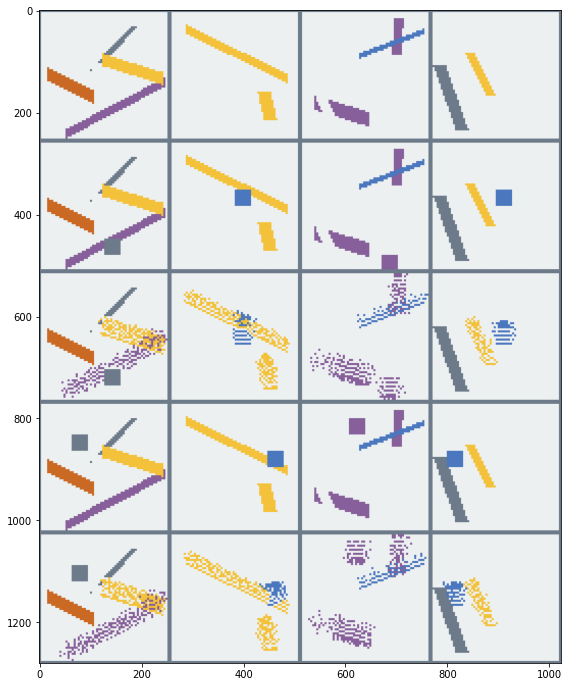

In [11]:
def show_row(env, wandb_name=None):
    imgs = env.render()
    fig = plt.figure(figsize=(4*4,4*3))
    axarr = fig.subplots(1, 1)
    axarr.imshow(imgs)
    plt.imshow(imgs)
    if wandb_name is not None:
        wandb.log({
            wandb_name: wandb.Image(fig)
        })
    del imgs
    plt.show()

env = PowderWorldPlaceEnv(False, ['empty', 'sand', 'water', 'wall', 'gas', 'wood'], 100000, 5, 0, 0)
# show_row(env)
actions = np.array([env.action_space.sample() for b in range(32)])
ob, rew, _, _ = env.step(actions)
show_row(env)

In [ ]:
from stable_baselines3 import PPO, DQN
import torch.nn as nn

from stable_baselines3.common.vec_env import VecMonitor, VecVideoRecorder
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor


class CustomCNN(BaseFeaturesExtractor):
    """
    :param observation_space: (gym.Space)
    :param features_dim: (int) Number of features extracted.
        This corresponds to the number of unit for the last layer.
    """

    def __init__(self, observation_space, features_dim=256, wm=None, wm_layer=0, env='place'):
        super(CustomCNN, self).__init__(observation_space, features_dim)
        # We assume CxHxW images (channels first)
        # Re-ordering will be done by pre-preprocessing or wrapper
        
        if wm == "None":
            wm = None
            if env == 'sand':
                n_input_channels = 20
            else:
                n_input_channels = 40
        
        if wm is not None:
            self.wm = WorldModel()
            self.wm.load_state_dict(torch.load('/data/scratch/kvfrans/wm_dr_data/wm_{}.pt'.format(wm)))
            self.wm_layer = wm_layer
            if self.wm_layer == 0:
                n_input_channels = 32
            elif self.wm_layer == 1:
                n_input_channels = 64
            elif self.wm_layer == 2:
                n_input_channels = 128
            elif self.wm_layer == 3:
                n_input_channels = 64
            elif self.wm_layer == 4:
                n_input_channels = 32
            sequential_layers = [
                nn.Conv2d(n_input_channels, 64, kernel_size=4, stride=2, padding=0),
                nn.ReLU(),
                nn.Flatten()
            ]
        else:
            self.wm = None
            sequential_layers = [
                nn.Conv2d(n_input_channels, 32, kernel_size=5, stride=2, padding=0),
                nn.ReLU(),
                nn.Conv2d(32, 64, kernel_size=5, stride=2, padding=0),
                nn.ReLU(),
                nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=0),
                nn.ReLU(),
                nn.Flatten()
            ]
        
        n_input_channels = observation_space.shape[0]
#         print(sequential_layers)
        self.cnn = nn.Sequential(*sequential_layers)

        # Compute shape by doing one forward pass
        with torch.no_grad():
            if self.wm is None:
                n_flatten = self.cnn(
                    torch.as_tensor(observation_space.sample()[None]).float()
                ).shape[1]
            else:
                n_flatten = self.cnn(
                    self.process_wm(torch.as_tensor(observation_space.sample()[None])).float()
                ).shape[1]

        self.linear = nn.Sequential(nn.Linear(n_flatten, features_dim), nn.ReLU())
        
    def process_wm(self, ob):
        if self.wm is None:
            return ob
        elif self.wm_layer < 3:
            return self.wm.encoder(ob[:,:14])[self.wm_layer]
        else:
            enc_ftrs = self.wm.encoder(ob[:,:14])
            dec_ftrs = self.wm.decoder.get_features(enc_ftrs[::-1][0], enc_ftrs[::-1][1:])
            return dec_ftrs[self.wm_layer-3]

    def forward(self, observations):
        if self.wm is not None:
            observations = self.process_wm(observations)
        return self.linear(self.cnn(observations))

class TensorboardCallback(BaseCallback):
    """
    Custom callback for plotting additional values in tensorboard.
    """

    def __init__(self, elems, num_tasks, num_lines, num_circles, num_squares, env):
        super(TensorboardCallback, self).__init__(0)
        self.eval_freq = 1024
        self.elems = elems
        self.num_tasks = num_tasks
        self.num_lines = num_lines
        self.num_circles = num_circles
        self.num_squares = num_squares
        self.env = env

    def _on_step(self) -> bool:
        # Log scalar value (here a random variable)
        if self.eval_freq > 0 and self.n_calls % self.eval_freq == 0:
            print("Testing on transfer task")
            if self.env == 'place':
                eval_env = PowderWorldPlaceEnv(test=True)
            else:
                eval_env = PowderWorldSandEnv(test=True)
            eval_env = VecMonitor(eval_env)
            episode_rewards, episode_lengths = evaluate_policy(
                self.model,
                eval_env,
                n_eval_episodes=(32*4),
                render=False,
                deterministic=False,
                return_episode_rewards=True,
            )
            mean_reward, std_reward = np.mean(episode_rewards), np.std(episode_rewards)
            self.logger.record('reward_test', mean_reward)
            if self.env == 'place':
                show_row(eval_env, 'pic_test')
            
            if self.env == 'place':
                eval_env = PowderWorldPlaceEnv(False, self.elems, self.num_tasks, self.num_lines, self.num_circles, self.num_squares)
            else:
                eval_env = PowderWorldSandEnv(False, self.elems, self.num_tasks, self.num_lines, self.num_circles, self.num_squares)
            eval_env = VecMonitor(eval_env)
            episode_rewards, episode_lengths = evaluate_policy(
                self.model,
                eval_env,
                n_eval_episodes=(32*4),
                render=False,
                deterministic=False,
                return_episode_rewards=True,
            )
            mean_reward, std_reward = np.mean(episode_rewards), np.std(episode_rewards)
            self.logger.record('reward_valid', mean_reward)
            if self.env == 'place':
                show_row(eval_env, 'pic_valid')
            
            
            if self.env == 'place':
                all_elems = ['empty', 'sand', 'water', 'wall', 'gas', 'wood']
                eval_env = PowderWorldPlaceEnv(False, all_elems, 1000000, 5, 0, 0)
            else:
                all_elems = ['empty', 'sand', 'water', 'wall', 'plant', 'stone', 'lava']
                eval_env = PowderWorldSandEnv(False, all_elems, 1000000, 5, 0, 0)
            eval_env = VecMonitor(eval_env)
            episode_rewards, episode_lengths = evaluate_policy(
                self.model,
                eval_env,
                n_eval_episodes=(32*4),
                render=False,
                deterministic=False,
                return_episode_rewards=True,
            )
            mean_reward, std_reward = np.mean(episode_rewards), np.std(episode_rewards)
            self.logger.record('reward_half', mean_reward)
            if self.env == 'place':
                show_row(eval_env, 'pic_half')
            
        return True

In [ ]:
def train(run_name, wm_name, wm_layer, num_elems, num_tasks, num_lines, num_circles, num_squares, alg, env):
    from wandb.integration.sb3 import WandbCallback
    run = wandb.init(
        project="powder_agent_6_{}".format(env),
        config={},
        sync_tensorboard=True,  # auto-upload sb3's tensorboard metrics
        monitor_gym=True,  # auto-upload the videos of agents playing the game
        save_code=False,  # optional
    )
    if run_name is not None:
        run.name = run_name
        
    all_elems = ['empty', 'sand', 'water', 'wall', 'plant', 'stone', 'lava']
    elems = all_elems[:num_elems]
    
    policy_kwargs = dict(
        features_extractor_class=CustomCNN,
        features_extractor_kwargs=dict(features_dim=20, wm=wm_name, wm_layer=wm_layer, env=env),
    )

    checkpoint_callback = TensorboardCallback(elems, num_tasks, num_lines, num_circles, num_squares, env)
    wandb_callback = WandbCallback(model_save_freq=10000, model_save_path=f"models/{run.name}", verbose=2)
    callback = CallbackList([checkpoint_callback, wandb_callback])

    if env == 'place':
        env = PowderWorldPlaceEnv(False, elems, num_tasks, num_lines, num_circles, num_squares)
    else:
        env = PowderWorldSandEnv(False, elems, num_tasks, num_lines, num_circles, num_squares)
    env = VecMonitor(env)
    
    if env == 'sand':
        env = VecVideoRecorder(env, "videos/{}".format(run.id), record_video_trigger=lambda x: x % 2000 == 0, video_length=200)

    if alg == 'PPO':
        model = PPO('CnnPolicy', env, policy_kwargs=policy_kwargs, n_steps=64, batch_size=64, verbose=1, tensorboard_log="runs/{}".format(run.id))
        model.learn(total_timesteps=500_000, callback=callback)
    elif alg == 'DQN':
        model = DQN('CnnPolicy', env, policy_kwargs=policy_kwargs, batch_size=256, buffer_size=100000, verbose=1, tensorboard_log="runs/{}".format(run.id))
        model.learn(total_timesteps=2_500_000, callback=callback, log_interval=2048)
    print(model)
    run.finish()
    
# def test_with_elems(elems, run_name):
#     import wandb
#     from wandb.integration.sb3 import WandbCallback
#     run = wandb.init(
#         project="powder_agent_elems_tests_2",
#         config={},
#         sync_tensorboard=True,  # auto-upload sb3's tensorboard metrics
#         monitor_gym=True,  # auto-upload the videos of agents playing the game
#         save_code=False,  # optional
#     )
#     if run_name is not None:
#         run.name = run_name+"_test_2"

#     # checkpoint_callback = TensorboardCallback()
#     wandb_callback = WandbCallback(model_save_freq=100, model_save_path=f"models/{run.name}", verbose=2)
#     callback = CallbackList([wandb_callback])

#     env = PowderWorldWindEnv(elems)
#     env = VecMonitor(env)
#     env = VecVideoRecorder(env, "videos/{}".format(run.id), record_video_trigger=lambda x: x % 2000 == 0, video_length=200)

#     model = PPO('CnnPolicy', env, policy_kwargs=policy_kwargs, n_steps=256, batch_size=512, verbose=1, tensorboard_log="runs/{}".format(run.id))
#     print(model)
#     model.learn(total_timesteps=500_000, callback=callback)
#     run.finish()

In [ ]:
# if 'ipykernel_launcher.py' in sys.argv[0]:
#     train_with_elems(['wall'], None)

In [ ]:
if not 'ipykernel_launcher.py' in sys.argv[0]:
    print("Loading args")
    import argparse
    parser = argparse.ArgumentParser()
    parser.add_argument('func') # Train or Test?
    parser.add_argument('--savedir')
    parser.add_argument('--wm_name')
    parser.add_argument('--wm_layer', type=int)
    parser.add_argument('--num_elems', type=int)
    parser.add_argument('--num_tasks', type=int)
    parser.add_argument('--num_lines', type=int)
    parser.add_argument('--num_circles', type=int)
    parser.add_argument('--num_squares', type=int)
    parser.add_argument('--alg')
    parser.add_argument('--env', default='place')
    args = parser.parse_args()
    print(args)
    
    if args.func == 'train':
        # Train a worldmodel on elems. Save as savedir.pt.
        train(args.savedir, args.wm_name, args.wm_layer, args.num_elems, args.num_tasks, args.num_lines, args.num_circles, args.num_squares, args.alg, args.env)

    elif args.func == 'test':
        pass
#         test_with_elems(args.elems, args.name)
    else:
        print("Invalid function!")
else:
    train('debug', 'None', 0, 3, 100000, 5, 0, 0, 'PPO')